Calculates heat transport timeseries in multiple experiments
Following code from Pangeo ocean heat content tutorial
https://gallery.pangeo.io/repos/NCAR/notebook-gallery/notebooks/Run-Anywhere/Ocean-Heat-Content/OHC_tutorial.html

Heat content = cp [T d(z)] for all z
             = density of seawater * specific heat of sea water *
               Temp of ocean chunk * depth of ocean chunk 
               for the whole water column
               

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import itertools
import xarray as xr
from Datasets import forcings, exp_set_dict, colors_dict
import Functions_data_analysis as fda
import Functions_load_output as flo
import Functions_plotting as fp

In [2]:
# Use importlib to reload modules after editing them
import importlib
importlib.reload(fda)

<module 'Functions_data_analysis' from '/glade/campaign/univ/ulnl0002/Gemma/Analysis/Functions_data_analysis.py'>

In [3]:
cdw_min_temp = 0.5 #degrees celsius

# choose region from shelf_region_dict in fda
region = 'shelf_box'

# sets = ['ic_1995','ic_2001','ic_2008']
sets = ['control','ic_1995','ic_2001','ic_2008']

n_months = 60 # if None, uses all data in runs. set to make it consistent

In [4]:
runs_nested = [exp_set_dict[set] for set in sets]
runs = [run for sublist in runs_nested for run in sublist]
runs

['control',
 'run_forc_erai_2015_rep_ic_1995',
 'run_forc_erai_1991_rep_ic_1995',
 'run_forc_erai_1982_rep_ic_1995',
 'run_forc_erai_1994_rep_ic_1995',
 'run_forc_erai_1992_rep_ic_1995',
 'run_forc_erai_1984_rep_ic_1995',
 'run_forc_erai_2009_rep_ic_1995',
 'run_forc_erai_2003_rep_ic_1995',
 'run_forc_erai_1989_rep_ic_1995',
 'run_forc_erai_2011_rep_ic_1995',
 'run_forc_erai_2015_rep_ic_2001',
 'run_forc_erai_1991_rep_ic_2001',
 'run_forc_erai_1982_rep_ic_2001',
 'run_forc_erai_1994_rep_ic_2001',
 'run_forc_erai_1992_rep_ic_2001',
 'run_forc_erai_1984_rep_ic_2001',
 'run_forc_erai_2009_rep_ic_2001',
 'run_forc_erai_2003_rep_ic_2001',
 'run_forc_erai_1989_rep_ic_2001',
 'run_forc_erai_2011_rep_ic_2001',
 'run_forc_erai_2015_rep_ic_2008',
 'run_forc_erai_1991_rep_ic_2008',
 'run_forc_erai_1982_rep_ic_2008',
 'run_forc_erai_1994_rep_ic_2008',
 'run_forc_erai_1992_rep_ic_2008',
 'run_forc_erai_1984_rep_ic_2008',
 'run_forc_erai_2009_rep_ic_2008',
 'run_forc_erai_2003_rep_ic_2008',
 'run_fo

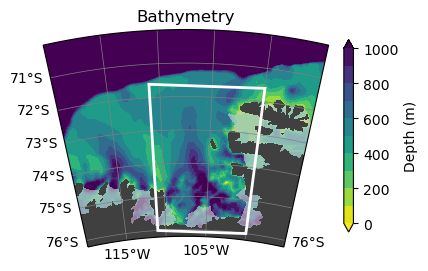

In [37]:
# Show locations of cross sections on bathymetry map
fp.plot_bathymetry_and_locs('AS_near',[region]) #add capability to plot boxes

In [5]:
# Calculate grid sizes for first experiment ahead of time so don't have to redo for each run
exp1_ds = flo.load_experiment_ds(runs[1], 'all', 'state_3d_set2')
if n_months != None:
    run_ds = exp1_ds.isel(time = slice(0,n_months))

# Only look at data between 200m and 1500m depth to exclude deep ocean and surface water
exp1_T_raw = exp1_ds.THETA
exp1_T_mid_depths = exp1_T_raw.sel(depth=slice(-200,-1500))

# Select data from shelf region
if region in fda.shelf_region_dict.keys():
    lat1,lat2,lon1,lon2 = fda.shelf_region_dict[region]
    exp1_T = exp1_T_mid_depths.sel(lat = slice(lat1,lat2),lon=slice(lon1,lon2))
shelf_grid_areas = fda.calc_grid_areas(exp1_T)
shelf_grid_areas.shape

(182, 132)

In [6]:
#set to True if you need to resave any set times
save_times = True
test_run = 'run_forc_erai_2015_rep_ic_1995'
times_fname = 'times_ic_1995.npy'
if save_times:
    test_ds = flo.load_experiment_ds(test_run, 'all', 'state_3d_set2')
    times = test_ds.time.values[0:n_months]
    times_dt64 = [np.datetime64(x) for x in times]
    np.save('Saved Arrays/CDW_Heat_Content/'+times_fname,times_dt64)

In [7]:
# pick up here on 5/31: replzce text with CDW with heat transport func

importlib.reload(fda)

# Load or calculate CDW heat content timeseries for all runs
hc_list = []
times_list = []
for run in runs:
    print(run)
    # try loading precalc CDW heat content
    try:
        hc = np.load('Saved Arrays/CDW_Heat_Content/'+run+'_'+str(cdw_min_temp)+'deg.npy')
        if run == 'control':
            hc_times = np.load('Saved Arrays/CDW_Heat_Content/times_control.npy')
        else:
            ic_set = run.split('rep_ic_')[1]
            hc_times = np.load('Saved Arrays/CDW_Heat_Content/times_ic_'+ic_set+'.npy')
            
    # Otherwise, calculate from scratch and save arrays
    except:
        if run != 'control':
            try:
                hc_times, hc = fda.calc_cdw_heat_content_tseries(run, region, cdw_min_temp, shelf_grid_areas, n_months = n_months)
            except:
                print(n_months,'not available in',run,' using all months available with shape:')
                hc_times, hc = fda.calc_cdw_heat_content_tseries(run, region, cdw_min_temp, shelf_grid_areas)
                print(hc.shape)
            print(hc)
            save_name = 'Saved Arrays/CDW_Heat_Content/'+run+'_'+str(cdw_min_temp)+'deg.npy'
            print('Saving new CDW heat content array as ',save_name)
            np.save(save_name,hc)
            ic_set = run.split('rep_ic_')[1]
            try:
                hc_times = np.load('Saved Arrays/CDW_Heat_Content/times_ic_'+ic_set+'.npy')
            except:
                np.save('Saved Arrays/CDW_Heat_Content/times_ic_'+ic_set+'.npy',hc_times)
        else:
            # load full run for control run
            hc_times, hc = fda.calc_cdw_volume_tseries(run, region, cdw_min_temp, shelf_grid_areas)
            save_name = 'Saved Arrays/CDW_Heat_Content/'+run+'_'+str(cdw_min_temp)+'deg.npy'
            print('Saving new CDW heat content array as ',save_name)
            np.save(save_name,hc)
            np.save('Saved Arrays/CDW_Heat_Content/times_control.npy',hc_times)

    hc_list.append(hc)
    times_list.append(hc_times)
    

control
run_forc_erai_2015_rep_ic_1995
run_forc_erai_1991_rep_ic_1995
run_forc_erai_1982_rep_ic_1995
run_forc_erai_1994_rep_ic_1995
run_forc_erai_1992_rep_ic_1995
run_forc_erai_1984_rep_ic_1995
run_forc_erai_2009_rep_ic_1995
run_forc_erai_2003_rep_ic_1995
run_forc_erai_1989_rep_ic_1995
run_forc_erai_2011_rep_ic_1995
run_forc_erai_2015_rep_ic_2001
run_forc_erai_1991_rep_ic_2001
run_forc_erai_1982_rep_ic_2001
run_forc_erai_1994_rep_ic_2001
run_forc_erai_1992_rep_ic_2001
run_forc_erai_1984_rep_ic_2001
run_forc_erai_2009_rep_ic_2001
run_forc_erai_2003_rep_ic_2001
run_forc_erai_1989_rep_ic_2001
run_forc_erai_2011_rep_ic_2001
run_forc_erai_2015_rep_ic_2008
run_forc_erai_1991_rep_ic_2008
run_forc_erai_1982_rep_ic_2008
run_forc_erai_1994_rep_ic_2008
run_forc_erai_1992_rep_ic_2008
run_forc_erai_1984_rep_ic_2008
run_forc_erai_2009_rep_ic_2008
run_forc_erai_2003_rep_ic_2008
run_forc_erai_1989_rep_ic_2008
run_forc_erai_2011_rep_ic_2008


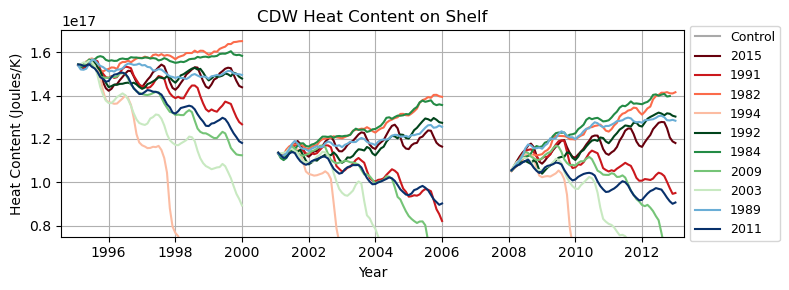

In [11]:
colors_list = [colors_dict[set] for set in sets]
colors = [item for sublist in colors_list for item in sublist]

fig = plt.figure()
fig.set_size_inches((8,3))
ax=plt.subplot(1,1,1)

for i in range(len(runs)):
    run = runs[i]
    # print(run)
    if run == 'control':
        ax.plot(times_list[i], hc_list[i], label='Control', color = 'darkgray')
    elif i < 11:
        label = run.split('run_forc_erai_')[1][0:4]
        ax.plot(times_list[i], hc_list[i], label=label, color = colors[i])
    else:
        try:
            ax.plot(times_list[i][0:n_months], hc_list[i][0:n_months], color = colors[i])
        except:
            run_len = len(hc_list[i])
            ax.plot(times_list[i][0:run_len], hc_list[i], color = colors[i])

ax.set_ylim(0.75e17,1.7e17)
ax.set_ylabel('Heat Content (Joules/K)')
ax.grid()
ax.set_xlabel('Year')
# ax.set_xlim(np.datetime64('1991-08-01'),np.datetime64('2018-04-01'))
ax.set_xlim(np.datetime64('1994-08-01'),np.datetime64('2013-04-01'))
plt.title('CDW Heat Content on Shelf')

ax.legend(ncol=1,fontsize=9,loc='center left',bbox_to_anchor=[1,0.5])


plt.subplots_adjust(top=0.95,bottom=0.06,hspace=0.2,wspace=.25,left=0.08,right=.97)

plt.tight_layout()
# plt.savefig('Plots/Figure_CDW_heat_content_on_shelf.png',dpi=600)

In [ ]:
# Testing is below

In [40]:
# Load one run for testing: 1982_1995
run_ds = flo.load_experiment_ds('run_forc_erai_1982_rep_ic_1995', 'all', 'state_3d_set2')
exp_T_raw = run_ds.THETA
# roughly narrow down shelf region (refine later)
lat1,lat2,lon1,lon2 = fda.shelf_region_dict[region]
exp_T = exp_T_raw.sel(lat = slice(lat1,lat2),depth=slice(-200,-1500),lon=slice(lon1,lon2))
exp_T


<xarray.DataArray 'THETA' (time: 63, depth: 36, lat: 182, lon: 132)>
dask.array<getitem, shape=(63, 36, 182, 132), dtype=float32, chunksize=(1, 36, 182, 132), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) >f4 -71.61 -71.64 -71.66 -71.69 ... -75.93 -75.96 -75.98
  * lon      (lon) >f4 -111.0 -110.9 -110.8 -110.7 ... -100.2 -100.1 -100.0
  * depth    (depth) >f4 -215.3 -237.3 -259.3 ... -1.306e+03 -1.409e+03
    rA       (lon, lat) >f4 dask.array<chunksize=(132, 182), meta=np.ndarray>
    Depth    (lon, lat) >f4 dask.array<chunksize=(132, 182), meta=np.ndarray>
    drF      (depth) >f4 dask.array<chunksize=(36,), meta=np.ndarray>
    PHrefC   (depth) >f4 dask.array<chunksize=(36,), meta=np.ndarray>
    hFacC    (depth, lon, lat) >f4 dask.array<chunksize=(36, 132, 182), meta=np.ndarray>
    maskC    (depth, lon, lat) bool dask.array<chunksize=(36, 132, 182), meta=np.ndarray>
    rhoRef   (depth) >f4 dask.array<chunksize=(36,), meta=np.ndarray>
    iter     (time) int64 dask.array<chunksize=(1,), meta=np.ndarray>
  * time     (time) object 1995-02-01 00:00:00 ... 2000-04-01 00:00:00
Attributes:
    standard_name:  THETA
    long_name:      Potential Temperature
    units:          degC

In [41]:
# Create binary mask for water cooler than CDW temp (takes a few secs)
exp_CDW_mask = xr.where(exp_T > cdw_min_temp, 1, 0) #shape (time, depth, lat, lon)
exp_CDW_mask = exp_CDW_mask.values #make it an np array
print('masked CDW water with shape',exp_CDW_mask.shape)

# mask but keep values
exp_CDW_vals = exp_T.where(exp_T > cdw_min_temp)
exp_CDW_vals_cels = exp_CDW_vals.values
#convert to Kelvin
exp_CDW_vals = exp_CDW_vals_cels + 273.15

# Calculate thicknesses of each layer
depths = exp_T.depth.values
layer_thicknesses = np.diff(-depths)

masked CDW water with shape (63, 36, 182, 132)


In [42]:
exp_CDW_vals[0,:,0,0]

array([273.9924 , 274.19916, 274.35468, 274.46606, 274.5463 , 274.6076 ,
       274.65527, 274.6876 , 274.70242, 274.70508, 274.7033 ,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan],
      dtype=float32)

In [43]:
# Calculate size of each grid cell
import math

def calculate_distance(coord1, coord2):
    # note coord1 and coord2 must be both lats or both lons (it subtracts them)
    # returns distance in km
    
    # Convert latitude or longitude values from degrees to radians
    coord1_rad = math.radians(coord1)
    coord2_rad = math.radians(coord2)

    # Earth radius in kilometers
    earth_radius = 6371.0

    # Calculate the difference (in lats or lons)
    dcoord = coord2_rad - coord1_rad

    # Calculate the distance using the Haversine formula
    distance = 2 * earth_radius * math.asin(math.sqrt(math.sin(dcoord/2)**2))

    return distance

n_lats, n_lons = len(exp_T.lat), len(exp_T.lon)
#n_lats,n_lons = 4,4
shelf_grid_areas = np.zeros((n_lats,n_lons))

# calculate area in each grid point in selected region
for i in range(n_lats-1):
    
    # Calculate lat distance of grid cell
    lat1,lat2 = exp_T.lat[i].values,exp_T.lat[i+1].values
    dist_i = calculate_distance(lat1,lat2)
    #print(lat1,lat2,dist_i)
    
    for j in range(n_lons-1):
        lon1,lon2 = exp_T.lon[j].values,exp_T.lon[j+1].values
        dist_j = calculate_distance(lon1,lon2)
        #print(lon1,lon2,dist_j)
        
        cell_area = dist_i * dist_j
        shelf_grid_areas[i,j] = cell_area
# shelf_grid_areas

In [48]:
shelf_grid_areas[0,0]

26.327351631215112

In [51]:
# calculate heat content (everything not masked)

n_times = exp_T.shape[0]
n_lats, n_lons = len(exp_T.lat), len(exp_T.lon)
# n_times,n_lats,n_lons = 3,3,3
print('n_lats,nlons=',n_lats,n_lons)
heat_content = np.zeros((n_times))
rho = 1026 #1026 kg/m^3
C = 3990 #specific heat of seawater (J/kgK)

for t in range(n_times):

    # start counter for cdw on the shelf
    shelf_heat_content = 0

    # for each cell, calculate volume of cdw
    for i in range(n_lats):
        for j in range(n_lons):
            # get thicknesses of CDW with dot product of array containining CDW depths (1's) and array containing depth thicknesses
            # this sums the total thicknesses of CDW in the cell
            # use nansum bc dot product cant handle nans
            temp_integral_ij = np.nansum(exp_CDW_vals[t,:,i,j][0:-1]*layer_thicknesses)
            # multiply heat content by grid area to get volume
            temp_integral_cell = temp_integral_ij * shelf_grid_areas[i,j]
            # multiply by c and p to get heat content
            heat_content_cell = rho * C * temp_integral_cell
            # add cell heat content to shelf counter
            shelf_heat_content += heat_content_cell
    if t %5 == 0:
        print('working on t...',t)
        print('shelf heat content:',shelf_heat_content)
    heat_content[t] = shelf_heat_content
    


n_lats,nlons= 182 132
working on t... 0
working on t... 5
working on t... 10
working on t... 15
working on t... 20
working on t... 25
working on t... 30
working on t... 35
working on t... 40
working on t... 45
working on t... 50
working on t... 55
working on t... 60


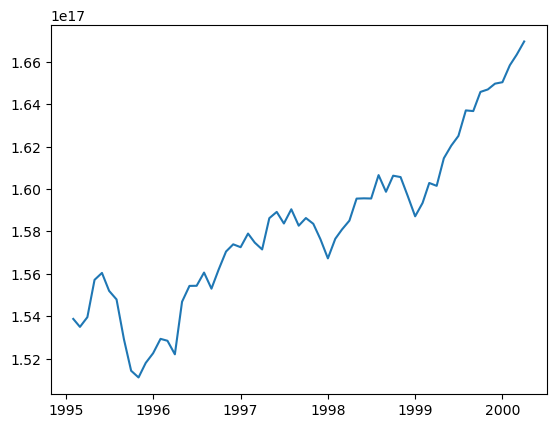

In [52]:
# Plot timeseries of cdw_vol
times = exp_T.time.values
times_dt64 = [np.datetime64(x) for x in times]
plt.plot(times_dt64,heat_content)